# Augmenting our Features and Improving Our Classification/Regression Model By Using LDA Topic Models as a Classification Input


Let us not forget to use our own features of recency of the articles and number of citations
--> Delta days between now and time of the publication 
--> number of times an articles has been quoted
--> try to engineer one hot encoding on the publishers to have some sort of feature presence of the pusblishers
--> continue your work but with a very small subset of the data

## Loading Data & packages

In [380]:
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import gensim.corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from datetime import datetime, timedelta
random.seed(10)


In [381]:
import pandas as pd
papers = pd.read_csv("C:/projects/machineLearning/hecCourse/metadataWithQuotationLabels.csv", usecols=['title', 
                                                                                                      'abstract', 
                                                                                                      'publish_time', 
                                                                                                      'authors', 
                                                                                                      'year',  
                                                                                                      'refid',
                                                                                                      'nbQuotations', 
                                                                                                      'references', 
                                                                                                      'cord_uid'])

In [383]:
# Print head
papers.head()
papers.shape

(93241, 9)

## Data Cleaning

In [384]:
# only keep rows with abstracts
papers = papers[-(papers['abstract'].isnull())]
# only keep rows with number of citations
papers = papers[-(papers['nbQuotations'].isna())]
# drop rows with NaN or NA
papers = papers.dropna()

In [385]:
## remove duplicates
papers = papers.drop_duplicates()

In [386]:
papers.shape

(93241, 9)

## distribution of the number of quotations

<AxesSubplot:xlabel='nbQuotations', ylabel='Density'>

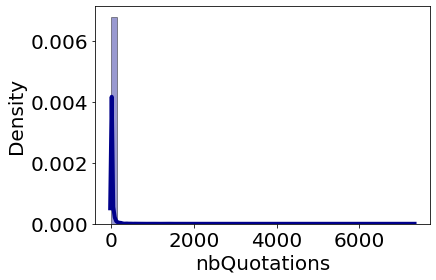

In [387]:
sns.distplot(papers['nbQuotations'], hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [388]:
papers['nbQuotations'].value_counts()

0.0       52937
2.0        7228
1.0        6664
4.0        3236
3.0        3076
          ...  
481.0         1
371.0         1
348.0         1
3993.0        1
232.0         1
Name: nbQuotations, Length: 462, dtype: int64

In [389]:
eq0 = sum(papers['nbQuotations'] == 0)
gt0lteq10 = sum((papers['nbQuotations'] > 0) & (papers['nbQuotations'] <=10))
gt0lteq10

28602

In [390]:
sum((papers['nbQuotations'] >= 0) & (papers['nbQuotations'] <=20))

86454

In [391]:
papers['nbQuotations'].describe()

count    93241.000000
mean         7.738709
std         55.348796
min          0.000000
25%          0.000000
50%          0.000000
75%          4.000000
max       7312.000000
Name: nbQuotations, dtype: float64

### The distibution of articles with citations is highly skewed
We will classify the articles popularity as follows:
- 0 --> 0 star
- 1 - 10 --> 1 star
- 10 -20 --> 2 stars
- 20 - 30 --> 3 stars
- 30 - 40 --> 4 stars
- 40 - 50 --> 5 stars
- gt 50 ------> 6 stars

## creation of the popularity feature

In [392]:
def bin(x):

    if x == 0:
        star = 0
    elif (x > 0) & (x <= 10):
        star = 1
    elif (x > 10) & (x <= 20):
        star = 2
    elif (x > 20) & (x <= 30):
        star = 3
    elif (x > 30) & (x <= 40):
        star = 4
    elif (x > 40) & (x <= 50):
        star = 5
    elif (x > 50) & (x <= 8000):
        star = 6
    return star

def citedOrNot(x):
    if x == 0:
        cited = 0
    elif x > 0:
        cited = 1
    return cited




In [393]:
papers['popularity'] = papers['nbQuotations'].apply(lambda x : bin(x))

In [394]:
papers['popularity'].value_counts()

0    52937
1    28602
2     4915
6     2713
3     2154
4     1207
5      713
Name: popularity, dtype: int64

## then you can create a feature about whether the article is cited or not cited --> we will also try to predict an article will be cited

In [395]:
papers['citedOrNot'] = papers['popularity'].apply(lambda x : citedOrNot(x))

In [396]:
papers['citedOrNot'].value_counts()

0    52937
1    40304
Name: citedOrNot, dtype: int64

## Creation of an additional feature about the length of the abstract

In [397]:
papers['popularity']

0        0
1        1
2        2
3        1
4        1
        ..
93236    6
93237    0
93238    0
93239    1
93240    0
Name: popularity, Length: 93241, dtype: int64

In [398]:
papers['text_len'] = papers['abstract'].apply(lambda x: len(x.split()))

## Creation of a new feature about number of days since publication

In [399]:
papers['publish_time'] = pd.to_datetime(papers['publish_time'])
papers['todaysDate'] = datetime.today()
papers['numberOfDaysSincePublication'] = (papers['todaysDate'] - papers['publish_time']) / np.timedelta64(1, 'D')
papers['numberOfDaysSincePublication'] = papers['numberOfDaysSincePublication'].astype(int)
papers['numberOfDaysSincePublication']

0        7095
1        7418
2        7408
3        7227
4        7149
         ... 
93236    4512
93237      61
93238     235
93239     179
93240     102
Name: numberOfDaysSincePublication, Length: 93241, dtype: int32

### Only select articles that have been published after March 2020


In [400]:
papers = papers[papers['publish_time'].dt.year.isin([2020]) & (papers['publish_time'].dt.month > 4)]

### remove all abstracts that are more than 2500 characters in length

In [401]:
papers = papers[-(papers['text_len'] >2500)]
papers.shape

(47937, 14)

## split dataframe 80% train + 20% test

In [402]:
msk = np.random.rand(len(papers)) < 0.8

papers_train = papers[msk]

papers_test = papers[~msk]

In [403]:
print(f'{len(papers_train)} articles in the train set')

38479 articles in the train set


In [404]:
print(f'{len(papers_test)} articles in the test set')

9458 articles in the test set


### Until our LDA model is trained, we then will do the EDA and train our train lda model on the papers_train set

## Assess popularity of the articles by abstract length

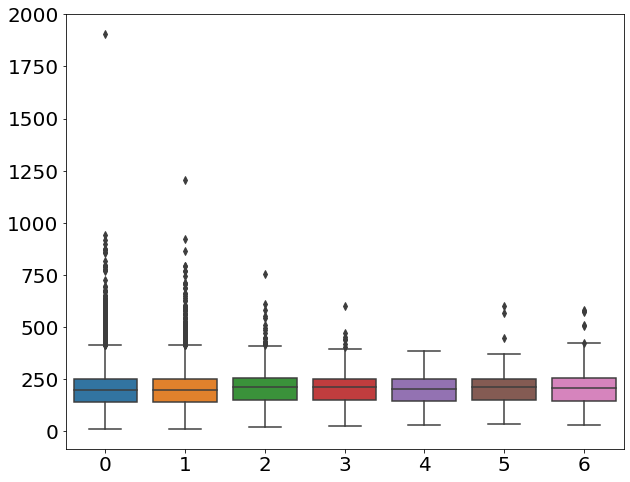

In [405]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 20})
sns.boxplot(x = 'popularity', y = 'text_len', data = papers_train)
plt.ylabel('')
plt.xlabel('');

In [406]:
pop = papers_train.popularity.to_list()
length = papers_train.text_len.to_list()
cor = np.corrcoef(pop, length)

In [407]:
cor

array([[1.        , 0.02432172],
       [0.02432172, 1.        ]])

### We observe the linear pearson correlation between abstract text length and article popularity is minimal at 3%

## There is good correlation between target and number of days since publication

In [408]:
cited = papers_train.citedOrNot.to_list()
days = papers_train.numberOfDaysSincePublication.to_list()
cor = np.corrcoef(cited, days)
cor

array([[1.        , 0.36320747],
       [0.36320747, 1.        ]])

### Number of articles in function of popularity level

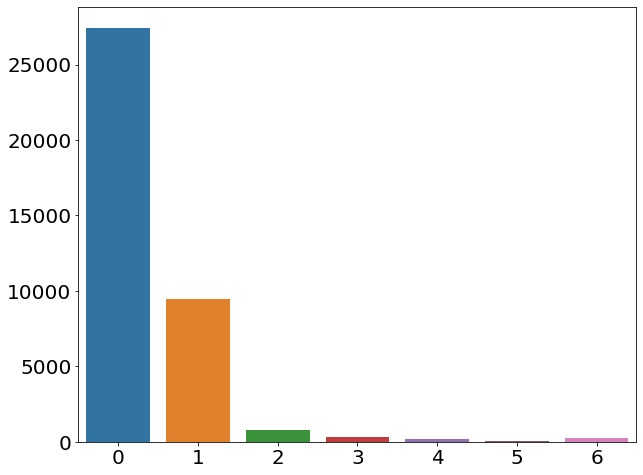

In [409]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 20})
sns.countplot('popularity', data = papers_train)
plt.ylabel('')
plt.xlabel('');


## More than 35000 articles are not cited once and approximately 30000 articles are cited more than once

In [410]:
papers_train.head(20)

,cord_uid,title,abstract,publish_time,authors,year,refid,nbQuotations,references,popularity,citedOrNot,text_len,todaysDate,numberOfDaysSincePublication
6240,odupmsen,True epidemic growth construction through harm...,"In this paper, we have proposed a two-phase pr...",2020-06-07,"['Steven Krantz', 'Peter Polyakov', 'Arni Rao']",2020,7e9403be2597e2d25496222a2c3f73f76a123fd8,8.0,"['694bc0d32925f80900d16223855459e7559aa7ba', '...",1,1,69,2020-12-06 18:11:38.369138,182
6686,ejaditj5,An adaptive parareal algorithm(),"In this paper, we consider the problem of acce...",2020-10-15,"['Y Maday', 'O Mula']",2020,0d356b454a202200d5191d74034c0b78f5bfe55c,0.0,"['d227650471fd3ee13b5f6e570c4e68e8c915f7c8', '...",0,0,276,2020-12-06 18:11:38.369138,52
7373,lfbjvche,Validation of RESP and PRESERVE score for ARDS...,BACKGROUND: RESP score and PRESERVE score have...,2020-05-02,"['Jan Petran', 'Thorsten Muelly', 'Rolf Dembin...",2020,b84ff14bd70d06a28890b555b81a30f48b33ace9,0.0,"['174d097f0764b61be3c8ce78b87f450cfc0819bc', '...",0,0,335,2020-12-06 18:11:38.369138,218
7383,3atdlr5k,St. Corona – eine Fürsprecherin gegen Seuchen?...,The knowledge of hagiography and hagiotherapy ...,2020-05-04,"['Friedrich Moll', 'Marie-Isabelle Schwarzburg...",2020,01462f086eaf885a2a5d95b2ce8d8e8959f6b0ea,0.0,"['8d306894a0d234681579877a2159dc8ca11496ae', '...",0,0,58,2020-12-06 18:11:38.369138,216
7399,7w5r7t4v,Long Noncoding RNA NRAV Promotes Respiratory S...,Respiratory syncytial virus (RSV) is an envelo...,2020-05-04,"['Jian Li', 'Miao Li', 'Xiuli Wang', 'Mengfei ...",2020,1f107fb4d0da8596d85c93b296f9c7c520ae3180,0.0,"['347cc5382d4cb030b0c55bb6906baca593ee2c6a', '...",0,0,352,2020-12-06 18:11:38.369138,216
7404,yhzf13bm,Sinensetin suppresses influenza a virus-trigge...,BACKGROUND: Human respiratory system infected ...,2020-05-05,"['Jiashun Li', 'Xiang Jie', '† ', 'Xiaoli Lian...",2020,80c724eb23c315994b085071710efcd1b59cd038,0.0,"['8d05db5ffa621b640fc1124afdbdc57bc0dd4300', '...",0,0,290,2020-12-06 18:11:38.369138,215
7405,8eclfq9k,A role for CIM6P/IGF2 receptor in memory conso...,Cation-independent mannose-6-phosphate recepto...,2020-05-05,"['Xiao-Wen Yu', 'Kiran Pandey', 'Aaron Katzman...",2020,1bba7aeb6d3700232a38d415056135f3c29c7efd,0.0,"['4ec25f35c08136dc6ce552fffa1b9fe93b7f935e', '...",0,0,150,2020-12-06 18:11:38.369138,215
7406,vxiv54gc,Management of Travel-Related Infectious Diseas...,PURPOSE OF REVIEW: Emergency physicians genera...,2020-05-06,"['Section Infectious Disease (j Glauser', ' Ed...",2020,598626808bffe102ab7afdc1abdb39ea369205a9,0.0,"['2699513948f9cc926cff38bd2c7177f4fc3012c3', '...",0,0,178,2020-12-06 18:11:38.369138,214
7409,79ahqp98,Successful treatment of mycobacterial infectio...,BACKGROUND: Hemophagocytic lymphohistiocytosis...,2020-05-05,"['Yan-Hong Wang', 'Jun-Hui Ba', 'Xiao-Wei Shi'...",2020,5fe087f1873b31b7b686b6f070135da9b24bfd45,0.0,"['638e18bfffb47665bf98485c1bf96e3a77a71716', '...",0,0,153,2020-12-06 18:11:38.369138,215
7410,fvq7at25,Scrub typhus as a rare cause of acute pyelonep...,BACKGROUND: Scrub typhus can present with atyp...,2020-05-06,"['Tulsi Bhattarai', 'Sujan Chandra Poudel', 'N...",2020,425d84865644fa5b823743c1e8a8fbd7a78089dc,0.0,"['80f455ebb89afd5bcd342595f64c8e16d4975b2c', '...",0,0,270,2020-12-06 18:11:38.369138,214


### Prepare LDA model with a bigram model

In [411]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [412]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stopWords = pd.read_csv("C:/projects/machineLearning/hecCourse/stopWords.csv", usecols=['index'])
stopWords = list(stopWords['index'])
stop_words.extend(stopWords)

In [413]:
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [414]:
import spacy  
import en_core_web_sm ## workaround in case of installation error, I had to do it
nlp = en_core_web_sm.load() ## workaround in case of installation error, I had to do it https://www.xspdf.com/resolution/50342159.html

In [415]:
def strip_newline(series):
    return [review.replace('\n','') for review in series]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [416]:
def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod

In [417]:
def get_corpus(df):
    """
    Get Bigram Model, Corpus, id2word mapping
    """
    
    df['abstract'] = strip_newline(df.abstract)
    words = list(sent_to_words(df.abstract))
    words = remove_stopwords(words)
    bigram = bigrams(words)
    bigram = [bigram[review] for review in words]
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=10, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word, bigram

In [418]:
train_corpus4, train_id2word4, bigram_train4 = get_corpus(papers_train)

In [419]:
print(train_corpus4[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 2), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 2), (31, 1), (32, 1)]


In [420]:
print(train_id2word4)

Dictionary(21991 unique tokens: ['adaptable', 'approach', 'available', 'based', 'combining']...)


In [421]:
print(bigram_train4[0])

['paper', 'proposed', 'two', 'phase', 'procedure', 'combining', 'discrete', 'graphs', 'wavelets', 'constructing', 'true', 'epidemic', 'growth', 'first', 'phase', 'graph', 'theory', 'based', 'approach', 'developed', 'update', 'partial', 'available', 'second_phase', 'used', 'partial', 'generate', 'plausible', 'complete', 'wavelets', 'provided', 'two', 'numerical_examples', 'procedure', 'novel', 'implementable', 'adaptable', 'machine_learning', 'modeling_framework']


In [422]:
%%time
import logging
import warnings
logging.basicConfig(filename='lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

numTopics = 8

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_train4 = gensim.models.ldamulticore.LdaMulticore(
                           corpus=train_corpus4,
                           num_topics = numTopics,
                           id2word=train_id2word4,
                           chunksize=5000,
                           passes=10,
                           alpha=0.31,
                           eta=0.91,
                           eval_every = 1)

Wall time: 3min 48s


In [423]:
lda_train4
lda_train4.save('lda_train4.model')

In [424]:
coherence_model_lda = CoherenceModel(model=lda_train4, texts=bigram_train4, dictionary=train_id2word4, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
coherence_lda

0.46452787881927954

### Make the training vectors

In [425]:
from tqdm import tqdm
train_vecs = []
for i in tqdm(range(len(papers_train))):
    top_topics = lda_train4.get_document_topics(train_corpus4[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(numTopics)]
    topic_vec.extend([papers_train.iloc[i].numberOfDaysSincePublication])
    # topic_vec.extend([papers_train.iloc[i].text_len])
    train_vecs.append(topic_vec)


100%|██████████| 38479/38479 [01:04<00:00, 601.01it/s]


In [426]:
train_vecs[2]

[0.0022773184,
 0.7907486,
 0.0024265652,
 0.0022187773,
 0.0023504677,
 0.16735283,
 0.030443266,
 0.0021821973,
 218]

## Getting the np.arrays ready for the CV fold training

In [427]:
X = np.array(train_vecs)

In [428]:
y = np.array(papers_train.citedOrNot)

In [429]:
pd.DataFrame(y).value_counts()

0    27449
1    11030
dtype: int64

In [430]:
import pickle

# save y array
with open('y.pkl', 'wb') as f:
    pickle.dump(y, f)
#save x array
with open('X.pkl', 'wb') as f:
    pickle.dump(X, f)
# save the train corpus 4 + the dictionary of id to word + the bigram list
with open('train_corpus4.pkl', 'wb') as f:
    pickle.dump(train_corpus4, f)
with open('train_id2word4.pkl', 'wb') as f:
    pickle.dump(train_id2word4, f)
with open('bigram_train4.pkl', 'wb') as f:
    pickle.dump(bigram_train4, f)


### training of a logistic regression, random forest, and neural network on whether or not an article will be cited
### PREDICTING WHETHER AN ARTICLE WILL BE CITED OR NOT


In [431]:
from sklearn.ensemble import RandomForestClassifier
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import fbeta_score, roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve
from sklearn.metrics import f1_score


## hyperparameters list creation

In [432]:
hyperparametersList = []
lrMinWeight = 1.1
sgdMinWeight = 1.1
rfMinWeight = 1.1
mlpAdamLearning = 0.0011
mlpSgdLearning = 0.0011
xgBoostScalePosWei = 3.1
runNumber = 10
for idx in range(runNumber):
    lrMinWeight = lrMinWeight - 0.1
    sgdMinWeight = sgdMinWeight - 0.1
    rfMinWeight = rfMinWeight - 0.1
    mlpAdamLearning = mlpAdamLearning -0.0001
    mlpSgdLearning = mlpSgdLearning -0.0001
    xgBoostScalePosWei = xgBoostScalePosWei -0.1
    hyperparametersList.append([lrMinWeight,sgdMinWeight, rfMinWeight,mlpAdamLearning, mlpSgdLearning, xgBoostScalePosWei])
print(hyperparametersList)

[[1.0, 1.0, 1.0, 0.001, 0.001, 3.0], [0.9, 0.9, 0.9, 0.0009, 0.0009, 2.9], [0.8, 0.8, 0.8, 0.0007999999999999999, 0.0007999999999999999, 2.8], [0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.0006999999999999999, 0.0006999999999999999, 2.6999999999999997], [0.6000000000000001, 0.6000000000000001, 0.6000000000000001, 0.0005999999999999998, 0.0005999999999999998, 2.5999999999999996], [0.5000000000000001, 0.5000000000000001, 0.5000000000000001, 0.0004999999999999998, 0.0004999999999999998, 2.4999999999999996], [0.40000000000000013, 0.40000000000000013, 0.40000000000000013, 0.0003999999999999998, 0.0003999999999999998, 2.3999999999999995], [0.30000000000000016, 0.30000000000000016, 0.30000000000000016, 0.0002999999999999998, 0.0002999999999999998, 2.2999999999999994], [0.20000000000000015, 0.20000000000000015, 0.20000000000000015, 0.00019999999999999982, 0.00019999999999999982, 2.1999999999999993], [0.10000000000000014, 0.10000000000000014, 0.10000000000000014, 9.999999999999

## Hyperparameter tuning of the training models (training and validation sets are managed through KFold of the sets)

In [433]:
%%time
from tqdm import tqdm

for ind, hyperparameters in tqdm(enumerate(hyperparametersList)):

    kf = KFold(5, shuffle=True, random_state=10)
    cv_lr_f1, cv_lrsgd_f1, cv_rf_f1, cv_mlp_f1_adam, cv_mlp_f1_sgd, cv_xgb_f1 = [], [], [], [], [], []
    cv_lr_acc, cv_lrsgd_acc, cv_rf_acc, cv_mlp_acc_adam, cv_mlp_acc_sgd, cv_xgb_acc = [], [], [], [], [], []
    cv_lr_rec, cv_lrsgd_rec, cv_rf_rec, cv_mlp_rec_adam, cv_mlp_rec_sgd, cv_xgb_rec = [], [], [], [], [], []
    cv_lr_prec, cv_lrsgd_prec, cv_rf_prec, cv_mlp_prec_adam, cv_mlp_prec_sgd, cv_xgb_prec = [], [], [], [], [], [] 

    for train_ind, val_ind in tqdm(kf.split(X, y)):
        # Assign CV IDX 80:20 training/validation amid the 80% constituting the training set
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind]
        
        # Scale Data
        scaler = StandardScaler()
        X_train_scale = scaler.fit_transform(X_train)
        X_val_scale = scaler.transform(X_val)

        print("The Data is scaled")

        # Logisitic Regression Train 80:20 training/validation amid the 80% constituting the training set
        lr = LogisticRegression(class_weight = {0: 1-hyperparameters[0],
                                                1: hyperparameters[0]},
                                solver='newton-cg',
                                fit_intercept=True
        ).fit(X_train_scale, y_train)
        print("The logistic regression is fitted")
        y_pred = lr.predict(X_val_scale) 

        cv_lr_f1.append(f1_score(y_val, y_pred, average='binary'))
        cv_lr_acc.append(metrics.accuracy_score(y_val, y_pred))
        cv_lr_rec.append(metrics.recall_score(y_val, y_pred))
        cv_lr_prec.append(metrics.precision_score(y_val, y_pred))

        # Logistic Regression Mini-Batch SGD 80:20 training/validation amid the 80% constituting the training set
        sgd = linear_model.SGDClassifier(class_weight= {0: 1-hyperparameters[1],
                                                        1: hyperparameters[1]},
                                        max_iter=1000,
                                        tol=1e-3,
                                        loss='log'
        ).fit(X_train_scale, y_train)
        
        y_pred = sgd.predict(X_val_scale)
        cv_lrsgd_f1.append(f1_score(y_val, y_pred, average='binary'))
        cv_lrsgd_acc.append(metrics.accuracy_score(y_val, y_pred))
        cv_lrsgd_rec.append(metrics.recall_score(y_val, y_pred))
        cv_lrsgd_prec.append(metrics.precision_score(y_val, y_pred))
        print("The logistic regression mini batch stochastic gradient descent is fitted")
        
        # Plain Vanilla Random Forest 80:20 training/validation amid the 80% constituting the training set
        clf=RandomForestClassifier(n_estimators=500,
                                class_weight = {0: hyperparameters[2],
                                                1: 1-hyperparameters[2]},  
                                random_state=10, 
                                warm_start=True)
        clf.fit(X_train_scale,y_train)
        y_pred = clf.predict(X_val_scale)
        cv_rf_f1.append(f1_score(y_val, y_pred, average='binary'))
        cv_rf_acc.append(metrics.accuracy_score(y_val, y_pred))
        cv_rf_rec.append(metrics.recall_score(y_val, y_pred))
        cv_rf_prec.append(metrics.precision_score(y_val, y_pred))
        print("The plain vanilla random forest is fitted")

        # Multi Layer Perceptron - adam 80:20 training/validation amid the 80% constituting the training set
        mlpAdam = MLPClassifier(batch_size='auto', warm_start=True, solver='adam', max_iter=500, learning_rate='adaptive', activation='logistic', learning_rate_init = hyperparameters[3])
        mlpAdam.fit(X_train_scale,y_train)
        y_pred = mlpAdam.predict(X_val_scale)
        cv_mlp_f1_adam.append(f1_score(y_val, y_pred, average='binary'))
        cv_mlp_acc_adam.append(metrics.accuracy_score(y_val, y_pred))
        cv_mlp_rec_adam.append(metrics.recall_score(y_val, y_pred))
        cv_mlp_prec_adam.append(metrics.precision_score(y_val, y_pred))
        print("The MLP ADAM fitted")

        # Multi Layer Perceptron - sgd 80:20 training/validation amid the 80% constituting the training set
        mlpSgd = MLPClassifier(batch_size='auto', warm_start=True, solver='sgd', max_iter=500, learning_rate='adaptive', activation='logistic', learning_rate_init = hyperparameters[4])
        mlpSgd.fit(X_train_scale,y_train)
        y_pred = mlpSgd.predict(X_val_scale)
        cv_mlp_f1_sgd.append(f1_score(y_val, y_pred, average='binary'))
        cv_mlp_acc_sgd.append(metrics.accuracy_score(y_val, y_pred))
        cv_mlp_rec_sgd.append(metrics.recall_score(y_val, y_pred))
        cv_mlp_prec_sgd.append(metrics.precision_score(y_val, y_pred))
        print("The MLP SGD fitted")

        # XGBoost predictions 80:20 training/validation amid the 80% constituting the training set
        xgbClf = XGBClassifier(n_estimators=500,
                            scale_pos_weight = hyperparameters[5],
                            learning_rate=0.01, 
                            objective='binary:logistic', 
                            booster='gbtree')
        xgbClf.fit(X_train_scale, y_train)
        y_pred = xgbClf.predict(X_val_scale)
        predictions = [round(value) for value in y_pred]
        cv_xgb_f1.append(f1_score(y_val, predictions, average='binary'))
        cv_xgb_acc.append(metrics.accuracy_score(y_val, predictions))
        cv_xgb_rec.append(metrics.recall_score(y_val, predictions))
        cv_xgb_prec.append(metrics.precision_score(y_val, predictions))
        print("The XGboost is fitted")

        accuracyLine = [np.mean(cv_lr_acc), hyperparameters[0], np.mean(cv_lrsgd_acc), hyperparameters[1], np.mean(cv_rf_acc), hyperparameters[2], np.mean(cv_mlp_acc_adam), hyperparameters[3], np.mean(cv_mlp_acc_sgd), hyperparameters[4], np.mean(cv_xgb_acc), hyperparameters[5]]
        f1ScoreLine = [np.mean(cv_lr_f1), hyperparameters[0], np.mean(cv_lrsgd_f1), hyperparameters[1], np.mean(cv_rf_f1), hyperparameters[2], np.mean(cv_mlp_f1_adam), hyperparameters[3], np.mean(cv_mlp_f1_sgd), hyperparameters[4], np.mean(cv_xgb_f1), hyperparameters[5]]
        recScoreLine = [np.mean(cv_lr_rec), hyperparameters[0], np.mean(cv_lrsgd_rec), hyperparameters[1], np.mean(cv_rf_rec), hyperparameters[2], np.mean(cv_mlp_rec_adam), hyperparameters[3], np.mean(cv_mlp_rec_sgd), hyperparameters[4], np.mean(cv_xgb_rec), hyperparameters[5]]
        precisionScoreLine = [np.mean(cv_lr_prec), hyperparameters[0], np.mean(cv_lrsgd_prec), hyperparameters[1], np.mean(cv_rf_prec), hyperparameters[2], np.mean(cv_mlp_prec_adam), hyperparameters[3], np.mean(cv_mlp_prec_sgd), hyperparameters[4], np.mean(cv_xgb_prec), hyperparameters[5]]
        perfTable = pd.DataFrame([accuracyLine, f1ScoreLine, recScoreLine, precisionScoreLine], index =['Accuracy', 'F1_Score', 'Recall Score', 'Precision'], columns=["Logistic Regression", "Parameters Logistic Regression", "Logistic Regression Mini-Batch SGD", "Parameters Logistic Regression Mini-Batch SGD", "Plain Vanilla Random Forest", "Parameters Random Forest" ,"MLP Classifier Adam", "Parameters MLP Classifier Adam", "MLP Classifier SGD", "Parameters MLP Classifier SGD","XGBoost", "Parameters XGBoost"])
    perfTable

    if ind == 0:
        performanceTable = perfTable
    else:
        performanceTable = pd.concat([performanceTable, perfTable])


0it [00:00, ?it/s]
0it [00:00, ?it/s]The Data is scaled
The logistic regression is fitted
The logistic regression mini batch stochastic gradient descent is fitted
The plain vanilla random forest is fitted
The MLP ADAM fitted
The MLP SGD fitted

1it [00:47, 47.07s/it]The XGboost is fitted
The Data is scaled
The logistic regression is fitted
The logistic regression mini batch stochastic gradient descent is fitted
The plain vanilla random forest is fitted
The MLP ADAM fitted
The MLP SGD fitted

2it [01:19, 42.62s/it]The XGboost is fitted
The Data is scaled
The logistic regression is fitted
The logistic regression mini batch stochastic gradient descent is fitted
The plain vanilla random forest is fitted
The MLP ADAM fitted
The MLP SGD fitted

3it [02:08, 44.71s/it]The XGboost is fitted
The Data is scaled
The logistic regression is fitted
The logistic regression mini batch stochastic gradient descent is fitted
The plain vanilla random forest is fitted
The MLP ADAM fitted
The MLP SGD fitted


## Performance Score

In [434]:
performanceTable

,Logistic Regression,Parameters Logistic Regression,Logistic Regression Mini-Batch SGD,Parameters Logistic Regression Mini-Batch SGD,Plain Vanilla Random Forest,Parameters Random Forest,MLP Classifier Adam,Parameters MLP Classifier Adam,MLP Classifier SGD,Parameters MLP Classifier SGD,XGBoost,Parameters XGBoost
Accuracy,0.286650,1.0,0.286650,1.0,0.713350,1.0,0.748018,0.0010,0.747187,0.0010,0.684399,3.0
F1_Score,0.445565,1.0,0.445565,1.0,0.000000,1.0,0.483823,0.0010,0.463528,0.0010,0.592465,3.0
Recall Score,1.000000,1.0,1.000000,1.0,0.000000,1.0,0.411982,0.0010,0.381113,0.0010,0.800281,3.0
Precision,0.286650,1.0,0.286650,1.0,0.000000,1.0,0.586139,0.0010,0.591759,0.0010,0.470378,3.0
Accuracy,0.477351,0.9,0.485511,0.9,0.745679,0.9,0.749344,0.0009,0.747031,0.0009,0.687752,2.9
F1_Score,0.512775,0.9,0.515790,0.9,0.516664,0.9,0.495925,0.0009,0.461069,0.0009,0.592923,2.9
Recall Score,0.959467,0.9,0.955606,0.9,0.474245,0.9,0.430778,0.0009,0.377585,0.0009,0.793304,2.9
Precision,0.349899,0.9,0.353304,0.9,0.567495,0.9,0.585754,0.0009,0.592257,0.0009,0.473406,2.9
Accuracy,0.636789,0.8,0.630578,0.8,0.746589,0.8,0.748486,0.0008,0.746667,0.0008,0.691234,2.8
F1_Score,0.571897,0.8,0.568151,0.8,0.508003,0.8,0.476784,0.0008,0.460263,0.0008,0.593418,2.8


### Save table


In [435]:
performanceTable.to_csv('./tuningTrainingTable.csv', encoding='utf-8', index=False)

### check the F1 Score rows

In [436]:
perfF1Score = performanceTable.loc[performanceTable.index == 'F1_Score']
perfF1Score

,Logistic Regression,Parameters Logistic Regression,Logistic Regression Mini-Batch SGD,Parameters Logistic Regression Mini-Batch SGD,Plain Vanilla Random Forest,Parameters Random Forest,MLP Classifier Adam,Parameters MLP Classifier Adam,MLP Classifier SGD,Parameters MLP Classifier SGD,XGBoost,Parameters XGBoost
F1_Score,0.445565,1.0,0.445565,1.0,0.000000,1.0,0.483823,0.0010,0.463528,0.0010,0.592465,3.0
F1_Score,0.512775,0.9,0.515790,0.9,0.516664,0.9,0.495925,0.0009,0.461069,0.0009,0.592923,2.9
F1_Score,0.571897,0.8,0.568151,0.8,0.508003,0.8,0.476784,0.0008,0.460263,0.0008,0.593418,2.8
F1_Score,0.584350,0.7,0.581758,0.7,0.503745,0.7,0.483496,0.0007,0.456570,0.0007,0.593686,2.7
F1_Score,0.549063,0.6,0.531148,0.6,0.493825,0.6,0.457510,0.0006,0.455030,0.0006,0.593742,2.6
F1_Score,0.463571,0.5,0.475845,0.5,0.489233,0.5,0.473692,0.0005,0.449990,0.0005,0.593838,2.5
F1_Score,0.308864,0.4,0.294940,0.4,0.481569,0.4,0.463118,0.0004,0.446690,0.0004,0.594013,2.4
F1_Score,0.095692,0.3,0.137749,0.3,0.471487,0.3,0.468162,0.0003,0.438150,0.0003,0.594021,2.3
F1_Score,0.000000,0.2,0.014282,0.2,0.460525,0.2,0.461529,0.0002,0.424867,0.0002,0.593117,2.2
F1_Score,0.000000,0.1,0.000000,0.1,0.453082,0.1,0.469904,0.0001,0.385142,0.0001,0.591700,2.1


In [439]:
perfAccScore = performanceTable.loc[performanceTable.index == 'Accuracy']
perfAccScore

,Logistic Regression,Parameters Logistic Regression,Logistic Regression Mini-Batch SGD,Parameters Logistic Regression Mini-Batch SGD,Plain Vanilla Random Forest,Parameters Random Forest,MLP Classifier Adam,Parameters MLP Classifier Adam,MLP Classifier SGD,Parameters MLP Classifier SGD,XGBoost,Parameters XGBoost
Accuracy,0.286650,1.0,0.286650,1.0,0.713350,1.0,0.748018,0.0010,0.747187,0.0010,0.684399,3.0
Accuracy,0.477351,0.9,0.485511,0.9,0.745679,0.9,0.749344,0.0009,0.747031,0.0009,0.687752,2.9
Accuracy,0.636789,0.8,0.630578,0.8,0.746589,0.8,0.748486,0.0008,0.746667,0.0008,0.691234,2.8
Accuracy,0.709790,0.7,0.705840,0.7,0.748954,0.7,0.747421,0.0007,0.746303,0.0007,0.694873,2.7
Accuracy,0.739416,0.6,0.741807,0.6,0.748278,0.6,0.746875,0.0006,0.746745,0.0006,0.698225,2.6
Accuracy,0.747161,0.5,0.745576,0.5,0.749448,0.5,0.747031,0.0005,0.746095,0.0005,0.702019,2.5
Accuracy,0.737909,0.4,0.737285,0.4,0.749967,0.4,0.747057,0.0004,0.746303,0.0004,0.706021,2.4
Accuracy,0.722550,0.3,0.726448,0.3,0.749630,0.3,0.746927,0.0003,0.745654,0.0003,0.710076,2.3
Accuracy,0.713350,0.2,0.714961,0.2,0.749682,0.2,0.747083,0.0002,0.744952,0.0002,0.713766,2.2
Accuracy,0.713350,0.1,0.713350,0.1,0.748824,0.1,0.747161,0.0001,0.742639,0.0001,0.717404,2.1


In [441]:
perfRecScore = performanceTable.loc[performanceTable.index == 'Recall Score']
perfRecScore

,Logistic Regression,Parameters Logistic Regression,Logistic Regression Mini-Batch SGD,Parameters Logistic Regression Mini-Batch SGD,Plain Vanilla Random Forest,Parameters Random Forest,MLP Classifier Adam,Parameters MLP Classifier Adam,MLP Classifier SGD,Parameters MLP Classifier SGD,XGBoost,Parameters XGBoost
Recall Score,1.000000,1.0,1.000000,1.0,0.000000,1.0,0.411982,0.0010,0.381113,0.0010,0.800281,3.0
Recall Score,0.959467,0.9,0.955606,0.9,0.474245,0.9,0.430778,0.0009,0.377585,0.0009,0.793304,2.9
Recall Score,0.846298,0.8,0.847774,0.8,0.456421,0.8,0.401231,0.0008,0.376927,0.0008,0.786062,2.8
Recall Score,0.711747,0.7,0.713864,0.7,0.444538,0.7,0.413889,0.0007,0.371862,0.0007,0.777648,2.7
Recall Score,0.553529,0.6,0.511612,0.6,0.428385,0.6,0.373865,0.0006,0.368939,0.0006,0.769284,2.6
Recall Score,0.381197,0.5,0.404083,0.5,0.418732,0.5,0.397893,0.0005,0.362414,0.0005,0.759875,2.5
Recall Score,0.204416,0.4,0.196218,0.4,0.405174,0.4,0.381205,0.0004,0.357315,0.0004,0.750259,2.4
Recall Score,0.051279,0.3,0.078496,0.3,0.389666,0.3,0.388849,0.0003,0.346031,0.0003,0.739955,2.3
Recall Score,0.000000,0.2,0.007367,0.2,0.372811,0.2,0.378361,0.0002,0.328725,0.0002,0.727808,2.2
Recall Score,0.000000,0.1,0.000000,0.1,0.363011,0.1,0.391011,0.0001,0.281417,0.0001,0.714388,2.1


In [442]:
perfPrecScore = performanceTable.loc[performanceTable.index == 'Precision']
perfPrecScore

,Logistic Regression,Parameters Logistic Regression,Logistic Regression Mini-Batch SGD,Parameters Logistic Regression Mini-Batch SGD,Plain Vanilla Random Forest,Parameters Random Forest,MLP Classifier Adam,Parameters MLP Classifier Adam,MLP Classifier SGD,Parameters MLP Classifier SGD,XGBoost,Parameters XGBoost
Precision,0.286650,1.0,0.286650,1.0,0.000000,1.0,0.586139,0.0010,0.591759,0.0010,0.470378,3.0
Precision,0.349899,0.9,0.353304,0.9,0.567495,0.9,0.585754,0.0009,0.592257,0.0009,0.473406,2.9
Precision,0.431902,0.8,0.427314,0.8,0.572832,0.8,0.590741,0.0008,0.591267,0.0008,0.476665,2.8
Precision,0.495666,0.7,0.491067,0.7,0.581304,0.7,0.584816,0.0007,0.591535,0.0007,0.480167,2.7
Precision,0.544742,0.6,0.554400,0.6,0.582948,0.6,0.593939,0.0006,0.593896,0.0006,0.483495,2.6
Precision,0.591652,0.5,0.581496,0.5,0.588454,0.5,0.587412,0.0005,0.593667,0.0005,0.487417,2.5
Precision,0.632663,0.4,0.635064,0.4,0.593683,0.4,0.591456,0.0004,0.595977,0.0004,0.491696,2.4
Precision,0.729332,0.3,0.726993,0.3,0.597039,0.3,0.588900,0.0003,0.597446,0.0003,0.496244,2.3
Precision,0.000000,0.2,0.307500,0.2,0.602528,0.2,0.592432,0.0002,0.600920,0.0002,0.500587,2.2
Precision,0.000000,0.1,0.000000,0.1,0.602923,0.1,0.588887,0.0001,0.611308,0.0001,0.505080,2.1


### The best contenders are then logistic regression and XGBoost

## Checking best weight for Logistic Regression

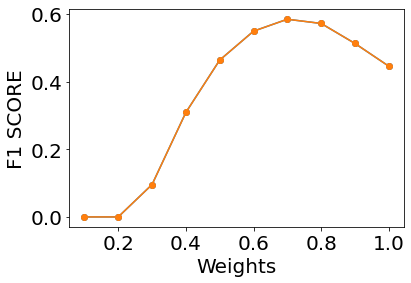

In [443]:
fig,ax=plt.subplots()
ax.plot(perfF1Score['Parameters Logistic Regression'], perfF1Score['Logistic Regression'], marker="o")
ax.set_xlabel("Weights")
ax.set_ylabel("F1 SCORE")
ax.plot(perfF1Score['Parameters Logistic Regression'], perfF1Score['Logistic Regression'], marker="o")
# plt.savefig('F1 Score Logistic Regression Evolution')
plt.show()

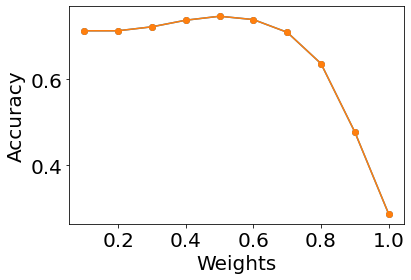

In [444]:
fig,ax=plt.subplots()
ax.plot(perfAccScore['Parameters Logistic Regression'], perfAccScore['Logistic Regression'], marker="o")
ax.set_xlabel("Weights")
ax.set_ylabel("Accuracy")
ax.plot(perfAccScore['Parameters Logistic Regression'], perfAccScore['Logistic Regression'], marker="o")
# plt.savefig('F1 Score Logistic Regression Evolution')
plt.show()

## Checking best weight for XGboost

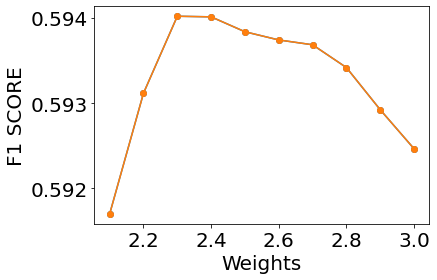

In [445]:
fig,ax=plt.subplots()
ax.plot(perfF1Score['Parameters XGBoost'], perfF1Score['XGBoost'], marker="o")
ax.set_xlabel("Weights")
ax.set_ylabel("F1 SCORE")
ax.plot(perfF1Score['Parameters XGBoost'], perfF1Score['XGBoost'], marker="o")
# plt.savefig('F1 Score Logistic Regression Evolution')
plt.show()

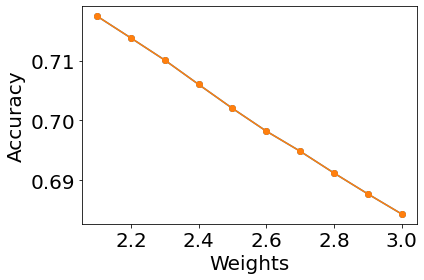

In [446]:
fig,ax=plt.subplots()
ax.plot(perfAccScore['Parameters XGBoost'], perfAccScore['XGBoost'], marker="o")
ax.set_xlabel("Weights")
ax.set_ylabel("Accuracy")
ax.plot(perfAccScore['Parameters XGBoost'], perfAccScore['XGBoost'], marker="o")
# plt.savefig('F1 Score Logistic Regression Evolution')
plt.show()

### The best models are then the logistic regression with 0.7 as weight on the minority class and XGBoost with scale_pos_weight being 2.6 (it means we put 2.6x times more emphasis on the minority class than the majority class (0))

### Let us now train these models with the same KFold and the hyperparameters mentioned above

In [447]:
kf = KFold(5, shuffle=True, random_state=10)
cv_lr_f1, cv_xgb_f1 = [], []
cv_lr_acc, cv_xgb_acc = [], []
cv_lr_rec, cv_xgb_rec = [], []
cv_lr_prec, cv_xgb_prec = [], [] 

for train_ind, val_ind in tqdm(kf.split(X, y)):
    # Assign CV IDX
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind]
    
    # Scale Data
    scaler = StandardScaler()
    X_train_scale = scaler.fit_transform(X_train)
    X_val_scale = scaler.transform(X_val)

    print("The Data is scaled")

    # Logisitic Regression
    lr = LogisticRegression(max_iter = 500,
                            class_weight = {0: 0.3,
                                            1: 0.7},
                            solver='lbfgs',
                            multi_class = 'ovr',
                            fit_intercept=True
    ).fit(X_train_scale, y_train)
    print("The logistic regression is fitted")
    y_pred = lr.predict(X_val_scale) 

    cv_lr_f1.append(f1_score(y_val, y_pred, average='binary'))
    cv_lr_acc.append(metrics.accuracy_score(y_val, y_pred))
    cv_lr_rec.append(metrics.recall_score(y_val, y_pred))
    cv_lr_prec.append(metrics.precision_score(y_val, y_pred))

    # XGBoost predictions
    xgbClf = XGBClassifier(n_estimators=1000,
                        scale_pos_weight = 2.60,
                        learning_rate=0.001, 
                        objective='binary:logistic', 
                        booster='gbtree', 
                        eval_metric='error')
    xgbClf.fit(X_train_scale, y_train)
    y_pred = xgbClf.predict(X_val_scale)
    predictions = [round(value) for value in y_pred]
    cv_xgb_f1.append(f1_score(y_val, predictions, average='binary'))
    cv_xgb_acc.append(metrics.accuracy_score(y_val, predictions))
    cv_xgb_rec.append(metrics.recall_score(y_val, predictions))
    cv_xgb_prec.append(metrics.precision_score(y_val, predictions))
    print("The XGboost is fitted")

0it [00:00, ?it/s]The Data is scaled
The logistic regression is fitted
1it [00:21, 21.15s/it]The XGboost is fitted
The Data is scaled
The logistic regression is fitted
2it [00:41, 21.03s/it]The XGboost is fitted
The Data is scaled
The logistic regression is fitted
3it [01:01, 20.72s/it]The XGboost is fitted
The Data is scaled
The logistic regression is fitted
4it [01:25, 21.69s/it]The XGboost is fitted
The Data is scaled
The logistic regression is fitted
5it [01:52, 22.52s/it]The XGboost is fitted



In [448]:
accuracyLineFinal = [np.mean(cv_lr_acc), np.mean(cv_xgb_acc)]
f1ScoreLineFinal = [np.mean(cv_lr_f1), np.mean(cv_xgb_f1)]
recScoreLineFinal = [np.mean(cv_lr_rec), np.mean(cv_xgb_rec)]
precisionScoreLineFinal = [np.mean(cv_lr_prec), np.mean(cv_xgb_prec)]
perfTableSelectModels = pd.DataFrame([accuracyLineFinal, recScoreLineFinal, f1ScoreLineFinal, precisionScoreLineFinal], index =['Validation Accuracy', 'Validation Recall Score', 'Validation F1_Score', 'Validation Precision'], columns=["Logistic Regression", "XGBoost"])
perfTableSelectModels

,Logistic Regression,XGBoost
Validation Accuracy,0.709790,0.690299
Validation Recall Score,0.711747,0.781056
Validation F1_Score,0.584350,0.591148
Validation Precision,0.495666,0.475583


## XGBoost seem to be the best model in terms of F1 Score but we will still use both Log and XGBoost during testing and check the different errors

### Let us also check the feature importance in the X predictors, this way we will have a sneak peak in the most important topics in terms of explaining popularity in the scientific community

### Logistic Regression

In [449]:
from sklearn.feature_selection import RFE
predictors = X_train_scale
selector = RFE(lr, n_features_to_select = 1)
selector = selector.fit(predictors, y_train)
order = selector.ranking_
order

array([6, 8, 3, 4, 2, 5, 9, 7, 1])

### we then can derive the ranked features in their impact of whether or not an article will be cited

In [450]:
from pprint import pprint
# Print the Keyword in the 8 topics
pprint(lda_train4.print_topics())


[(0,
  '0.009*"cases" + 0.007*"model" + 0.007*"epidemic" + 0.006*"countries" + '
  '0.006*"population" + 0.006*"number" + 0.006*"de" + 0.005*"pandemic" + '
  '0.005*"infection" + 0.005*"transmission"'),
 (1,
  '0.052*"patients" + 0.008*"group" + 0.007*"treatment" + 0.006*"results" + '
  '0.006*"severe" + 0.006*"associated" + 0.006*"patient" + 0.005*"compared" + '
  '0.005*"risk" + 0.005*"mortality"'),
 (2,
  '0.008*"covid_pandemic" + 0.007*"pandemic" + 0.007*"health" + 0.006*"care" + '
  '0.005*"research" + 0.004*"based" + 0.003*"also" + 0.003*"impact" + '
  '0.003*"management" + 0.003*"results"'),
 (3,
  '0.027*"sars_cov" + 0.010*"infection" + 0.009*"virus" + 0.006*"disease" + '
  '0.005*"ace" + 0.005*"cells" + 0.005*"viral" + 0.005*"patients" + '
  '0.005*"human" + 0.005*"cov"'),
 (4,
  '0.006*"based" + 0.004*"also" + 0.004*"human" + 0.004*"using" + 0.003*"used" '
  '+ 0.003*"model" + 0.003*"approach" + 0.003*"system" + 0.003*"potential" + '
  '0.003*"development"'),
 (5,
  '0.011*"p

### XGBoost

In [451]:
from sklearn.feature_selection import RFE
predictors = X_train_scale
selector = RFE(xgbClf, n_features_to_select = 1)
selector = selector.fit(predictors, y_train)
order = selector.ranking_
order

array([5, 7, 3, 6, 2, 9, 4, 8, 1])

### We observe that the most important features in predicting whether an article will be cited are topic number 4, topic number 7 and number of days since publication

### Let us now predict the test sets and check the articles that are going to be cited or not

In [452]:
papers_test.head(3)

,cord_uid,title,abstract,publish_time,authors,year,refid,nbQuotations,references,popularity,citedOrNot,text_len,todaysDate,numberOfDaysSincePublication
7247,7uir2epv,Update on Ebola Treatment Center Costs and Sus...,We surveyed 56 Ebola treatment centers (ETCs) ...,2020-05-08,"['Jocelyn Herstein', 'Aurora Le', 'Lily Mcnult...",2020,8168f0a1d2b671d63e1a398d2212ce7205719e92,0.0,"['8a58e482222ba196b5373a41d16e93e29581e16a', '...",0,0,47,2020-12-06 18:11:38.369138,212
7364,e0c2f8f4,Monotonicity properties for a ratio of finite ...,"In the paper, the authors consider a ratio of ...",2020-05-01,"['Feng Qi', 'Dongkyu Lim']",2020,6275a04dcef754533403c295b14d6a9fd0c6de37,0.0,"['ddab80551d1e7ea208d124a62268e2b51433a9ed', '...",0,0,30,2020-12-06 18:11:38.369138,219
7387,nbt7ocyy,Vaping induced pneumonitis: a small community ...,BACKGROUND: Electronic cigarettes/e-cigarettes...,2020-05-04,"['Andrew Silverman', 'Haseeb Siddique', 'Vikas...",2020,b47bcdb80bd4a7569a2bf7f85833d8b71ab56a98,0.0,"['7b02d656be5d1ccf62a02493bfd96504bcc2fdb8', '...",0,0,209,2020-12-06 18:11:38.369138,216


## Get the bigrams for the test sets

In [453]:
def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod

In [454]:
def strip_newline(series):
    return [review.replace('\n','') for review in series]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

### bring in the train id2word dictionary to prepare the corpus with the bigram

In [455]:
with open('train_id2word4.pkl', 'rb') as f:
    train_id2word = pickle.load(f)

In [456]:
def get_bigram(df):
    """
    For the test data we only need the bigram data built from the test,
    . This is a requirement from the gensim functions
    """
    df['abstract'] = strip_newline(df.abstract)
    words = list(sent_to_words(df.abstract))
    words = remove_stopwords(words)
    bigram = bigrams(words)
    bigram = [bigram[review] for review in words]
    return bigram

In [457]:
bigram_test = get_bigram(papers_test)

### No need to train a new LDA model, we just need to re-load the one we created for the training data and will apply the same to get the topic features from the test set

In [458]:
lda_train4 = gensim.models.ldamulticore.LdaMulticore.load('lda_train4.model')

### Using the train dict to build the new corpus on the test sets

In [459]:
test_corpus = [train_id2word.doc2bow(text) for text in bigram_test]

In [460]:
from tqdm import tqdm
test_vecs = []
for i in tqdm(range(len(papers_test))):
    top_topics = lda_train4.get_document_topics(test_corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(numTopics)]
    topic_vec.extend([papers_test.iloc[i].numberOfDaysSincePublication])
    # topic_vec.extend([papers_train.iloc[i].text_len]) # length review
    test_vecs.append(topic_vec)

100%|██████████| 9458/9458 [00:14<00:00, 645.88it/s]


### let us make sure we created test vecs for each article in the test set

In [461]:
if len(test_vecs) == papers_test.shape[0]:
    print(f'We created a test vector from the topic modelling features for each of the articles in the test set. There are {len(test_vecs)} ')

We created a test vector from the topic modelling features for each of the articles in the test set. There are 9458 


### Let us get the arrays of predictors and the arrays of target to predict

In [462]:
import numpy as np
Xtest = np.array(test_vecs)

In [463]:
ytest = np.array(papers_test.citedOrNot)

In [464]:
ss = StandardScaler()
XtestScaled = ss.fit_transform(Xtest)

### Predictions on the test set with the previous models

In [465]:
def predictTestResults(modelList = [], XtestScaled = '', ytest = ''):
    accuracyLineTest = []
    recallLineTest = []
    f1ScoreLineTest = []
    precLineTest = []
    for model in modelList:
        y_pred_clf = model.predict(XtestScaled)
        accuracyLineTest.append(metrics.accuracy_score(ytest, y_pred_clf))
        recallLineTest.append(metrics.recall_score(ytest, y_pred_clf))
        f1ScoreLineTest.append(metrics.f1_score(ytest, y_pred_clf, average='binary'))
        precLineTest.append(metrics.precision_score(ytest, y_pred_clf))

    return pd.DataFrame([accuracyLineTest,recallLineTest,f1ScoreLineTest,precLineTest], index=['Test Accuracy', 'Test Recall', 'Test F1_Score', 'Test Precision'], columns=['Logistic Regression', 'XGBoost']) 
        



In [471]:
resultsTest = predictTestResults(modelList = [lr, xgbClf], XtestScaled = XtestScaled, ytest = ytest)

## save results

In [474]:
resultsTest

,Logistic Regression,XGBoost
Test Accuracy,0.720131,0.702368
Test Recall,0.741886,0.806415
Test F1_Score,0.594826,0.600085
Test Precision,0.496423,0.477828


In [473]:
resultsTest.to_csv('./resultsTest.csv', encoding='utf-8', index=False)

## Confusion Table & ROC Curve

## XGBoost

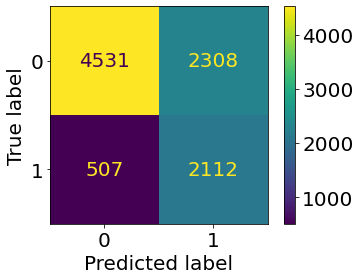

In [467]:
plot_confusion_matrix(xgbClf, XtestScaled, ytest)

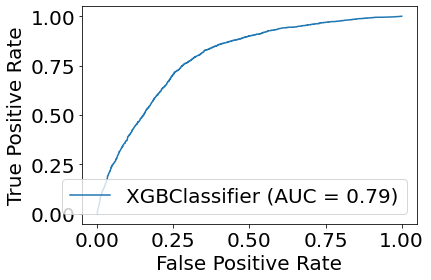

In [468]:
plot_roc_curve(xgbClf, XtestScaled, ytest)

## Logistic Regression

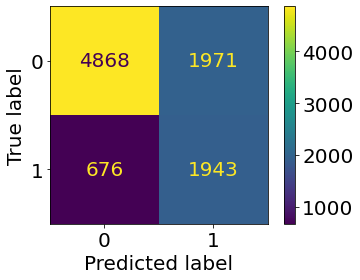

In [469]:
plot_confusion_matrix(lr, XtestScaled, ytest)

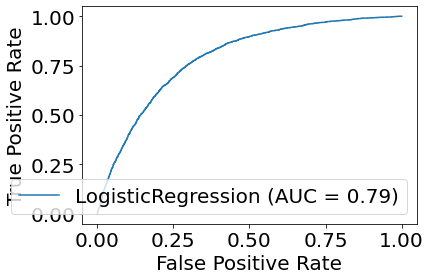

In [470]:
plot_roc_curve(lr, XtestScaled, ytest)